In [1]:
import os
import json

from pathlib import Path
from collections import defaultdict, Counter
from itertools import chain, starmap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load Historic PSPS Data

In [2]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

### Load Weather Station index (ws)

In [3]:
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)
ws.head()

,StationNbr,Name,City,RegionalOffice,County,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes,SitingDesc,Latitude,Longitude
0,1,Fresno/F.S.U. USDA,Fresno,South Central Region Office,Fresno,6/7/1982,9/25/1988,False,True,340,Grass,36º48'52N,-119º43'54W,"['93766', '93762', '93761', '93760', '93759', ...",NaN,36.814444,-119.73167
1,2,FivePoints,Five Points,South Central Region Office,Fresno,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N,-120º6'46W,['93624'],NaN,36.336222,-120.11291
2,3,Beach /Santa Cruz CO,Watsonville,South Central Region Office,Santa Cruz,5/30/1982,8/25/1986,False,True,10,Grass,36º52'50N,-121º47'36W,"['95077', '95076', '95075', '95019', '95018']",NaN,36.880556,-121.79333
3,4,Webb /Santa Cruz CO,Watsonville,South Central Region Office,Santa Cruz,5/30/1982,4/29/1988,False,True,230,Grass,36º58'21N,-121º43'34W,"['95077', '95076', '95075', '95019', '95018']",NaN,36.972500,-121.72611
4,5,Shafter,Shafter,South Central Region Office,Kern,6/1/1982,12/31/2050,True,True,360,Grass,35º31'57N,-119º16'54W,"['93263', '93280', '93388']",NaN,35.532556,-119.28179


In [12]:
ws[["Latitude", "Longitude"]].mean().values

array([  36.21586267, -119.70822928])

In [4]:
ws_cat_columns = ["StationNbr", "City", "County"]
ws_real_columns = ["Elevation"]
ws.columns

Index(['StationNbr', 'Name', 'City', 'RegionalOffice', 'County', 'ConnectDate',
       'DisconnectDate', 'IsActive', 'IsEtoStation', 'Elevation',
       'GroundCover', 'HmsLatitude', 'HmsLongitude', 'ZipCodes', 'SitingDesc',
       'Latitude', 'Longitude'],
      dtype='object')

### Load Weather Report data (wr)

In [5]:
wr = pd.read_csv("../data/weather/weather_report.csv", parse_dates=["Date"])

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
0,2018-12-01,335,100,2,english,93624,hourly,41.6,39.8,0.0,...,0.0,NaN,0.0,93.0,2.6,57.4,0.0,8.3,201.0,2.7
1,2018-12-01,335,200,2,english,93624,hourly,43.9,39.5,0.0,...,0.0,NaN,0.0,85.0,2.6,57.3,0.0,8.2,239.0,3.4
2,2018-12-01,335,300,2,english,93624,hourly,41.7,39.1,0.0,...,0.0,NaN,0.0,90.0,1.2,57.1,0.0,8.1,5.0,1.8
3,2018-12-01,335,400,2,english,93624,hourly,39.2,37.9,0.0,...,0.0,NaN,0.0,95.0,1.0,57.0,0.0,7.7,127.0,1.7
4,2018-12-01,335,500,2,english,93624,hourly,37.0,36.2,0.0,...,0.0,NaN,0.0,97.0,2.0,56.8,0.0,7.2,180.0,2.0


In [52]:
max_winds.describe()

count    151.000000
mean      19.974834
std        6.359614
min        5.400000
25%       15.200000
50%       19.900000
75%       23.700000
max       36.400000
Name: HlyWindSpd (MPH), dtype: float64

In [40]:
max_winds = wr.groupby("Station")["HlyWindSpd (MPH)"].max()
max_winds = max_winds[max_winds < 100]
ws_wind = ws.merge(max_winds, left_on="StationNbr", right_on="Station")
ws_wind = ws_wind.rename(columns={"HlyWindSpd (MPH)": "WindSpd"})

<AxesSubplot:>

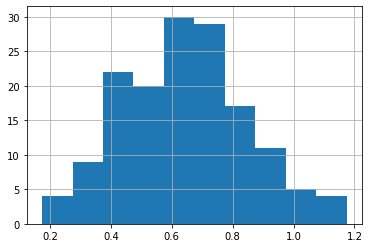

In [51]:
(max_winds/31).hist()

In [31]:
ws[["StationNbr","Latitude", "Longitude"]].set_index("StationNbr")

,Latitude,Longitude
StationNbr,,
1,36.814444,-119.731670
2,36.336222,-120.112910
3,36.880556,-121.793330
4,36.972500,-121.726110
5,35.532556,-119.281790
...,...,...
260,41.798331,-122.463425
261,41.533989,-122.532279
262,38.065692,-121.071747


In [32]:
ws.merge(max_winds, left_on="StationNbr", right_on="Station")

,StationNbr,Name,City,RegionalOffice,County,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes,SitingDesc,Latitude,Longitude,HlyWindSpd (MPH)
0,2,FivePoints,Five Points,South Central Region Office,Fresno,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N,-120º6'46W,['93624'],NaN,36.336222,-120.112910,18.1
1,5,Shafter,Shafter,South Central Region Office,Kern,6/1/1982,12/31/2050,True,True,360,Grass,35º31'57N,-119º16'54W,"['93263', '93280', '93388']",NaN,35.532556,-119.281790,22.1
2,6,Davis,Davis,North Central Region Office,Yolo,7/17/1982,12/31/2050,True,True,60,Grass,38º32'8N,-121º46'35W,"['95618', '95617', '95616']",NaN,38.535694,-121.776360,23.1
3,7,Firebaugh/Telles,Firebaugh,South Central Region Office,Fresno,9/22/1982,12/31/2050,True,False,185,Grass,36º51'4N,-120º35'27W,"['93622', '93665', '93620']",NaN,36.851222,-120.590920,20.1
4,12,Durham,Chico,Northern Region Office,Butte,10/19/1982,12/31/2050,True,True,130,Grass,39º36'31N,-121º49'28W,"['95974', '95958', '95938']",NaN,39.608639,-121.824430,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,260,Montague,Montague,Northern Region Office,Siskiyou,9/20/2019,12/31/2050,True,True,2663,Grass,41º47'54N,-122º27'48W,"['96038', '96044', '96064', '96097']",NaN,41.798331,-122.463425,30.3
149,261,Gazelle,Gazelle,Northern Region Office,Siskiyou,9/18/2019,12/31/2050,True,True,2743,Grass,41º32'2N,-122º31'56W,"['96034', '96038', '96064', '96094']",NaN,41.533989,-122.532279,36.2
150,262,Linden,Linden,North Central Region Office,San Joaquin,2/26/2020,12/31/2050,True,True,111,Grass,38º3'56N,-121º4'18W,"['95240', '95236', '95227', '95237', '95252', ...",NaN,38.065692,-121.071747,22.9
151,263,Smith River,Crescent City,Northern Region Office,Del Norte,10/7/2020,12/31/2050,True,True,22,Grass,41º53'41N,-124º9'54W,"['95532', '95567']",NaN,41.894592,-124.165043,19.2


In [6]:
# wr = wr[~wr.duplicated()]
# wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100
# wr["Time"] = wr["Date"] + wr["Hour"]

In [429]:
wr_dt_columns = ["Date", "Hour", "Time"]
wr_ts_columns = ['HlyAirTmp (F)', 'HlyRelHum (%)', 'HlyWindSpd (MPH)']
wr_cat_columns = ["Station"]
wr.columns

Index(['Date', 'Julian', 'Hour', 'Station', 'Standard', 'ZipCodes', 'Scope',
       'HlyAirTmp (F)', 'HlyDewPnt (F)', 'HlyEto (in)', 'HlyNetRad (Ly/day)',
       'HlyAsceEto (in)', 'HlyAsceEtr (in)', 'HlyPrecip (in)', 'HlyRelHum (%)',
       'HlyResWind (MPH)', 'HlySoilTmp (F)', 'HlySolRad (Ly/day)',
       'HlyVapPres (mBars)', 'HlyWindDir (°)', 'HlyWindSpd (MPH)', 'Time'],
      dtype='object')

In [408]:
ws_wr = wr.merge(ws,left_on="Station", right_on="StationNbr")
ws_wr.head()

,Date,Julian,Hour,Station,Standard,ZipCodes_x,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes_y,SitingDesc
0,2018-12-01,335,01:00:00,2,english,93624,hourly,41.6,39.8,0.0,...,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN
1,2018-12-01,335,02:00:00,2,english,93624,hourly,43.9,39.5,0.0,...,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN
2,2018-12-01,335,03:00:00,2,english,93624,hourly,41.7,39.1,0.0,...,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN
3,2018-12-01,335,04:00:00,2,english,93624,hourly,39.2,37.9,0.0,...,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN
4,2018-12-01,335,05:00:00,2,english,93624,hourly,37.0,36.2,0.0,...,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN


In [416]:
ws_wr_ts_columns = wr_ts_columns
ws_wr_cat_columns = ["Station", "City", "County"]
ws_wr_real_columns = ["Elevation"]

In [417]:
ws_wr_ts_columns

['HlyAirTmp (F)',
 'HlyDewPnt (F)',
 'HlyEto (in)',
 'HlyNetRad (Ly/day)',
 'HlyAsceEto (in)',
 'HlyAsceEtr (in)',
 'HlyPrecip (in)',
 'HlyRelHum (%)',
 'HlyResWind (MPH)',
 'HlySoilTmp (F)',
 'HlySolRad (Ly/day)',
 'HlyVapPres (mBars)',
 'HlyWindDir (°)',
 'HlyWindSpd (MPH)']

### Start/End Dates for Dec-Jan PSPS Events

In [373]:
se_dates = source[["start", "end"]]
se_dates = se_dates[~se_dates.duplicated()].sort_values(by="start").reset_index(drop=True)
se_dates.iloc[6:]

,start,end
6,2020-12-04,2020-12-14
7,2020-12-16,2020-12-24
8,2021-01-12,2021-01-21


### Matching Notifications of PSPS Event by County against CIMIS Data

In [374]:
notifications = pd.read_csv("../data/2021/deenergization_2021.csv", parse_dates=True)

notif_by_county = notifications.County.value_counts().sort_values()

counties = []
for county in notif_by_county.index:
     for c in county.split(";"):
            counties.append(c.title())

psps_county_stations = ws[ws.County.isin(counties)].StationNbr

len(set(counties)), len(psps_county_stations.values)

(9, 102)

In [375]:
wind_max = wr[wr.Station.isin(psps_county_stations.values)][["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max = wind_max[(wind_max > 25) & (wind_max < 60)].dropna()
wind_max

,HlyWindSpd (MPH)
Station,
125,30.6
197,29.5
204,28.0
234,26.1


In [376]:
ws[ws.StationNbr.isin(wind_max.index)]

,StationNbr,Name,City,RegionalOffice,County,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes,SitingDesc
124,125,Arvin-Edison,Arvin,South Central Region Office,Kern,3/22/1995,12/31/2050,True,True,500,Grass,35º12'20N / 35.205583,-118º46'42W / -118.778410,['93203'],NaN
196,197,Palmdale,Palmdale,Southern Region Office,Los Angeles,4/6/2005,12/31/2050,True,True,2550,Grass,34º36'54N / 34.614981,-118º1'57W / -118.032490,"['93534', '93535', '93543', '93550', '93552', ...",NaN
203,204,Santa Clarita,Santa Clarita,Southern Region Office,Los Angeles,12/4/2006,12/31/2050,True,True,1410,Grass,34º25'35N / 34.426361,-118º31'3W / -118.517580,['91350'],NaN
233,234,Newberry Springs II,Newberry Springs,Southern Region Office,San Bernardino,2/25/2015,11/29/2020,True,True,1930,Grass,34º53'0N / 34.883472,-116º48'37W / -116.810247,"['92311', '92312', '92327', '92365', '92398']",NaN


### When do Wind Speed and Humidity achieve max/min values, respectively

In [206]:
crossings = wr[(wr["HlyWindSpd (MPH)"] > wr["HlyRelHum (%)"]) & (wr["HlyRelHum (%)"] > 0)]
crossings.head()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
14825,2019-01-20,20,18:00:00,41,english,"92281, 92257, 92233",hourly,58.1,-36.9,0.00,...,NaN,0.0,1.0,2.7,45.2,1.0,0.2,132.0,2.8,2019-01-20 18:00:00
14834,2019-01-21,21,03:00:00,41,english,"92281, 92257, 92233",hourly,61.7,-8.9,0.00,...,NaN,0.0,5.0,7.1,45.0,0.0,1.0,263.0,8.3,2019-01-21 03:00:00
14835,2019-01-21,21,04:00:00,41,english,"92281, 92257, 92233",hourly,62.9,-26.7,0.01,...,NaN,0.0,2.0,9.6,44.8,0.0,0.4,265.0,11.4,2019-01-21 04:00:00
14847,2019-01-21,21,16:00:00,41,english,"92281, 92257, 92233",hourly,67.8,-5.1,0.01,...,NaN,0.0,5.0,13.2,45.7,537.0,1.2,294.0,13.6,2019-01-21 16:00:00
14854,2019-01-21,21,23:00:00,41,english,"92281, 92257, 92233",hourly,49.9,-36.9,0.00,...,NaN,0.0,2.0,2.1,46.3,0.0,0.2,276.0,2.9,2019-01-21 23:00:00


In [207]:
crossings.Date.value_counts().sort_index().loc["2021-01-17":"2021-01-20"]

2021-01-17     25
2021-01-18    115
2021-01-19    118
Name: Date, dtype: int64

In [208]:
station_crossings = crossings[(crossings.Date >= "2021-01-17") & (crossings.Date <= "2021-01-20")].Station.value_counts().sort_values(ascending=False)
station_crossings.head()

204    24
198    15
6      15
125    12
215    12
Name: Station, dtype: int64

In [209]:
station_crossings.index

Int64Index([204, 198,   6, 125, 215, 243, 139, 121, 217, 222, 152, 211, 247,
            140, 220, 262, 103,  88, 226, 221, 256, 212, 242, 206,  92,  91,
            129, 160, 144, 235, 248, 257, 187, 143, 254,  77, 116,  84,  70,
            228,  62, 224, 209, 253, 191],
           dtype='int64')

In [210]:
crossings[(crossings.Station == 44)].sort_values("Date").tail()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
326174,2021-01-15,15,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.6,15.1,0.02,...,NaN,0.0,8.0,10.5,52.5,913.0,3.0,5.0,10.6,2021-01-15 15:00:00
326175,2021-01-15,15,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.2,14.1,0.01,...,NaN,0.0,7.0,7.7,52.9,560.0,2.9,7.0,8.0,2021-01-15 16:00:00
326198,2021-01-16,16,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.5,26.1,0.02,...,NaN,0.0,12.0,11.8,52.7,865.0,4.8,5.0,12.4,2021-01-16 15:00:00
326196,2021-01-16,16,13:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,82.3,25.5,0.02,...,NaN,0.0,12.0,13.8,51.9,1303.0,4.7,8.0,14.0,2021-01-16 13:00:00
326199,2021-01-16,16,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,81.9,25.2,0.01,...,NaN,0.0,12.0,12.8,53.1,520.0,4.6,2.0,13.0,2021-01-16 16:00:00


### Visualizations by Station

In [211]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# plt.rc('font', **font)

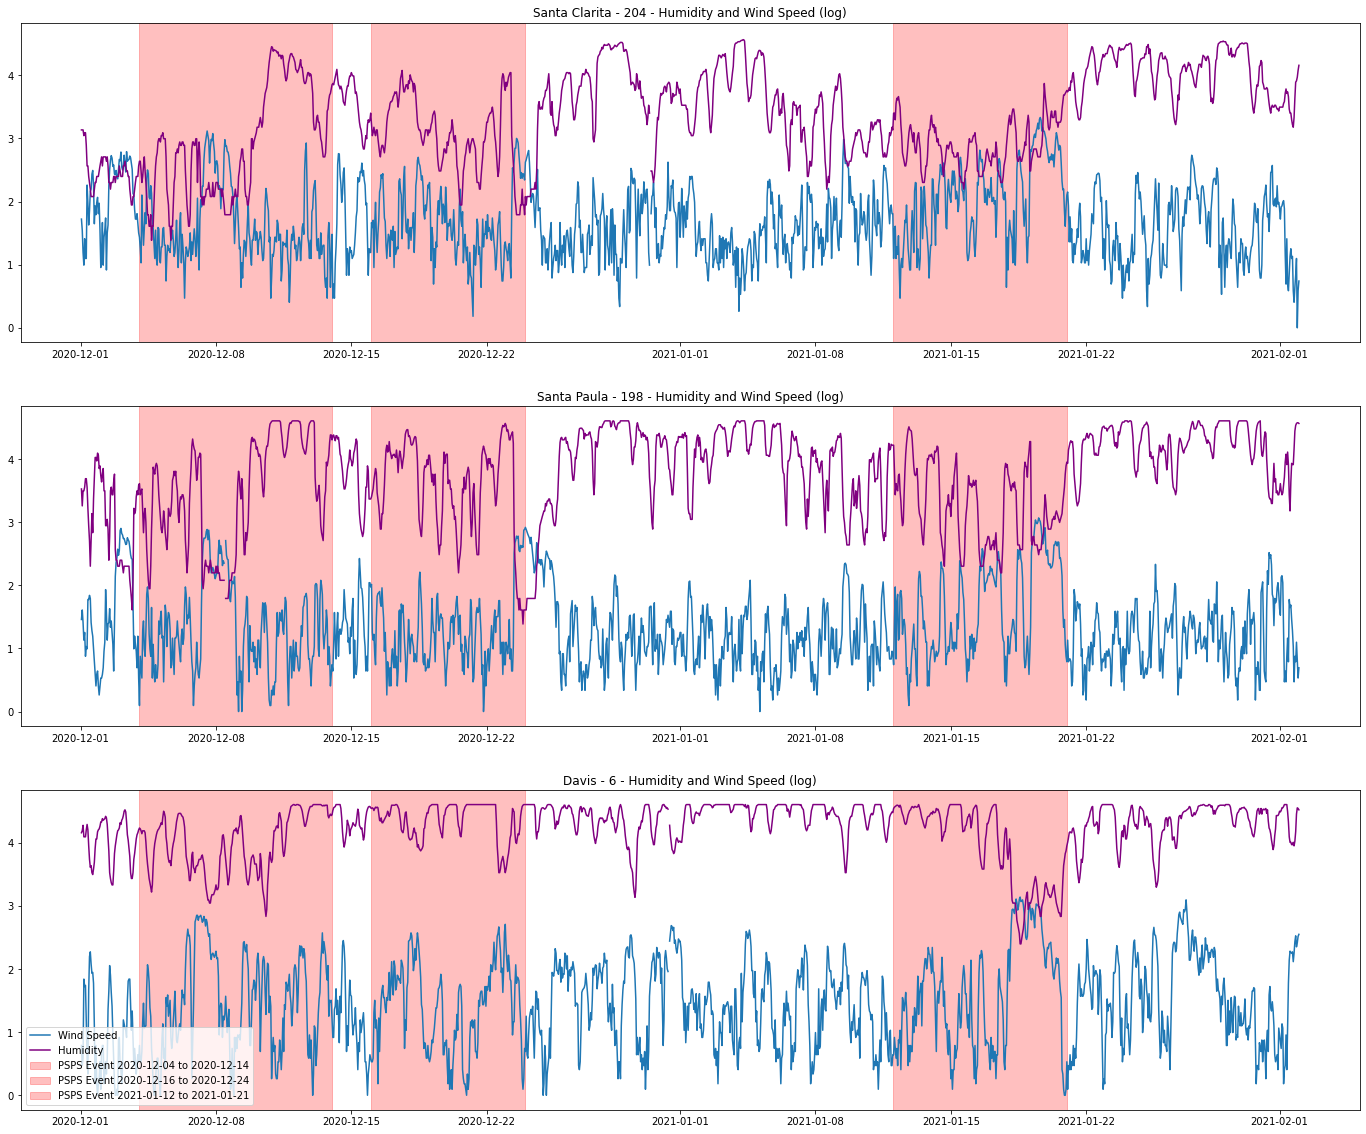

In [52]:
stations = station_crossings.head().index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations)-2, 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
# plt.savefig("../images/wind_hum_log.png")


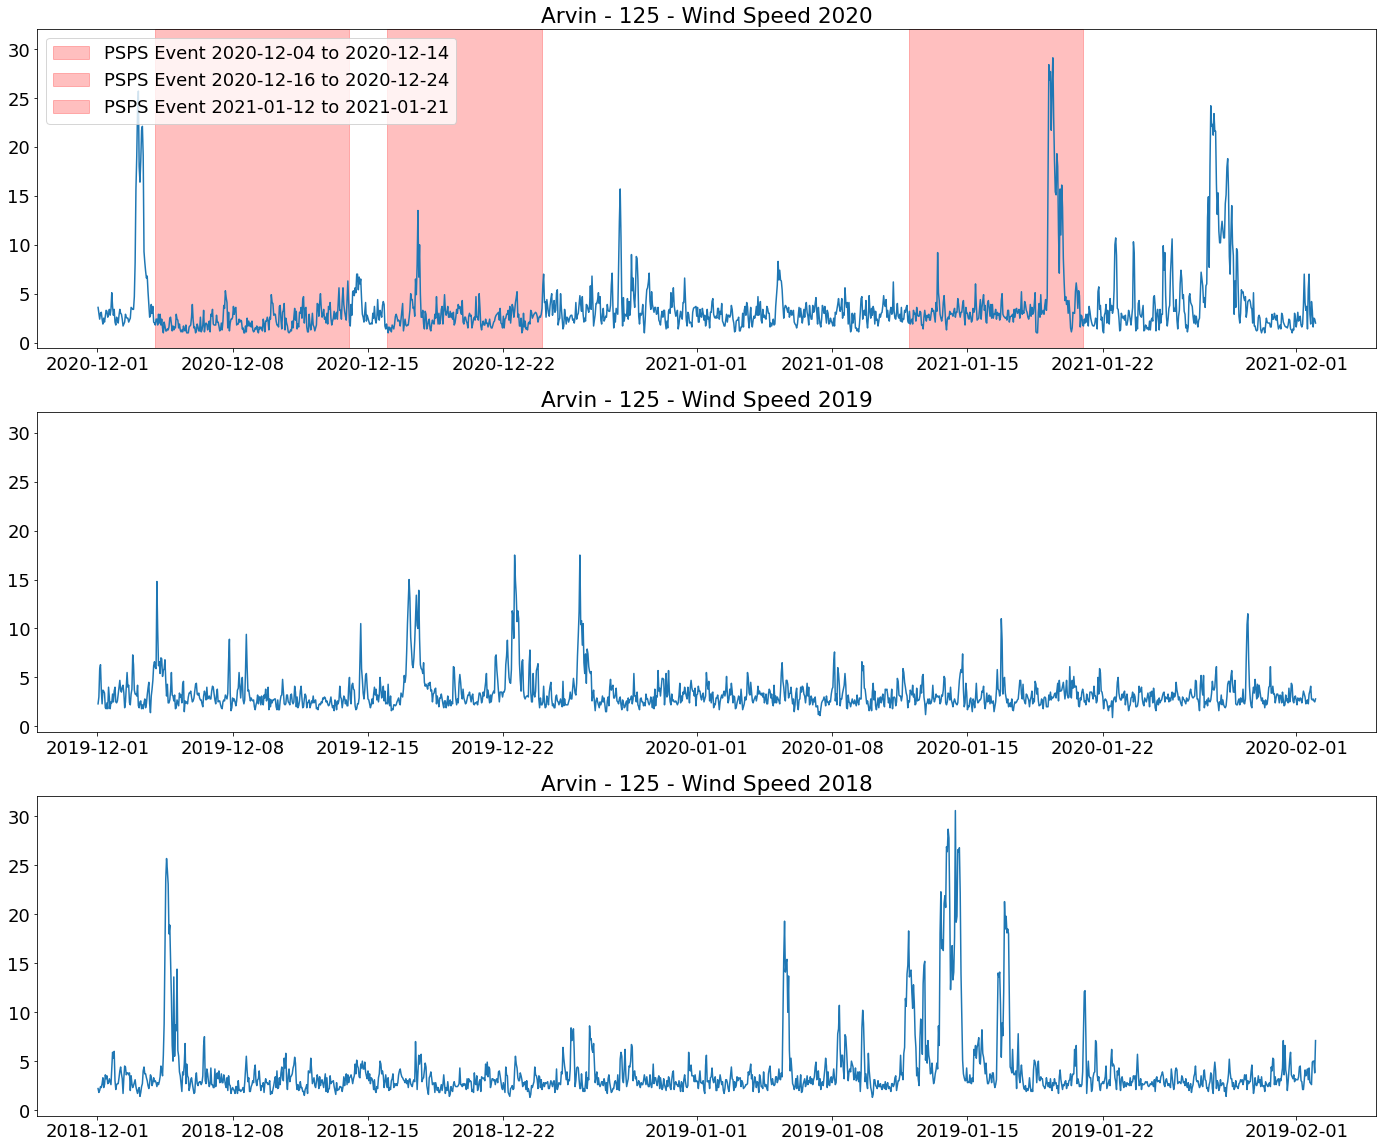

In [56]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
    v_ax.set_title("{} - {} - Wind Speed {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_wind.png")


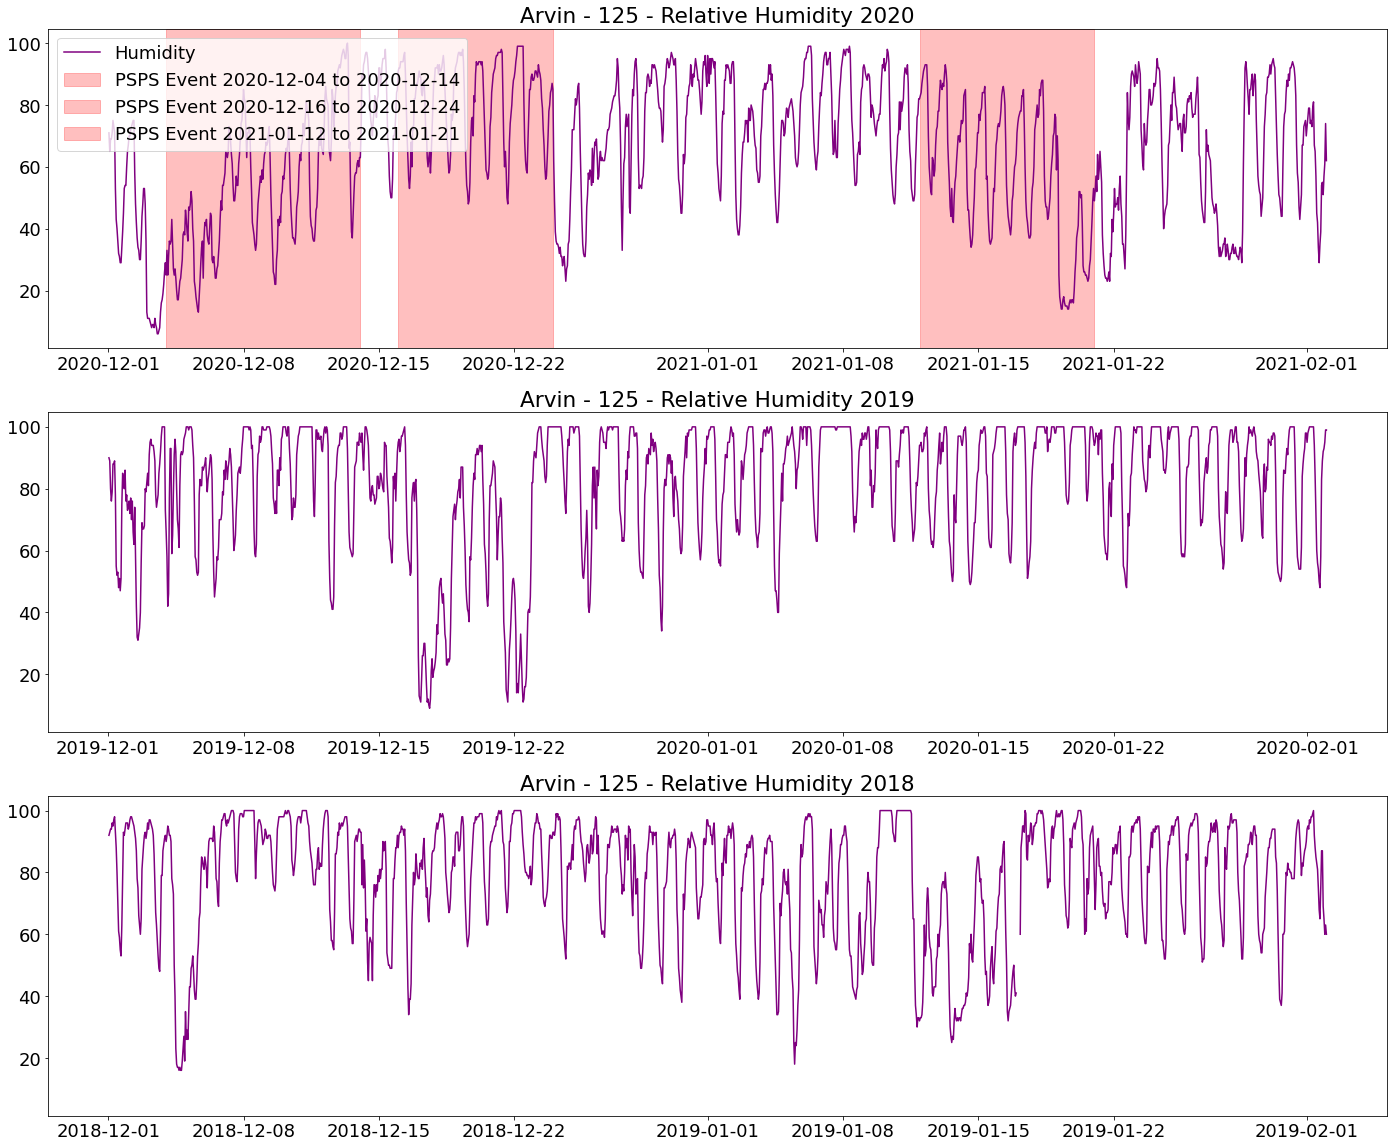

In [54]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="purple", label="Humidity")
    v_ax.set_title("{} - {} - Relative Humidity {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_humidity.png")


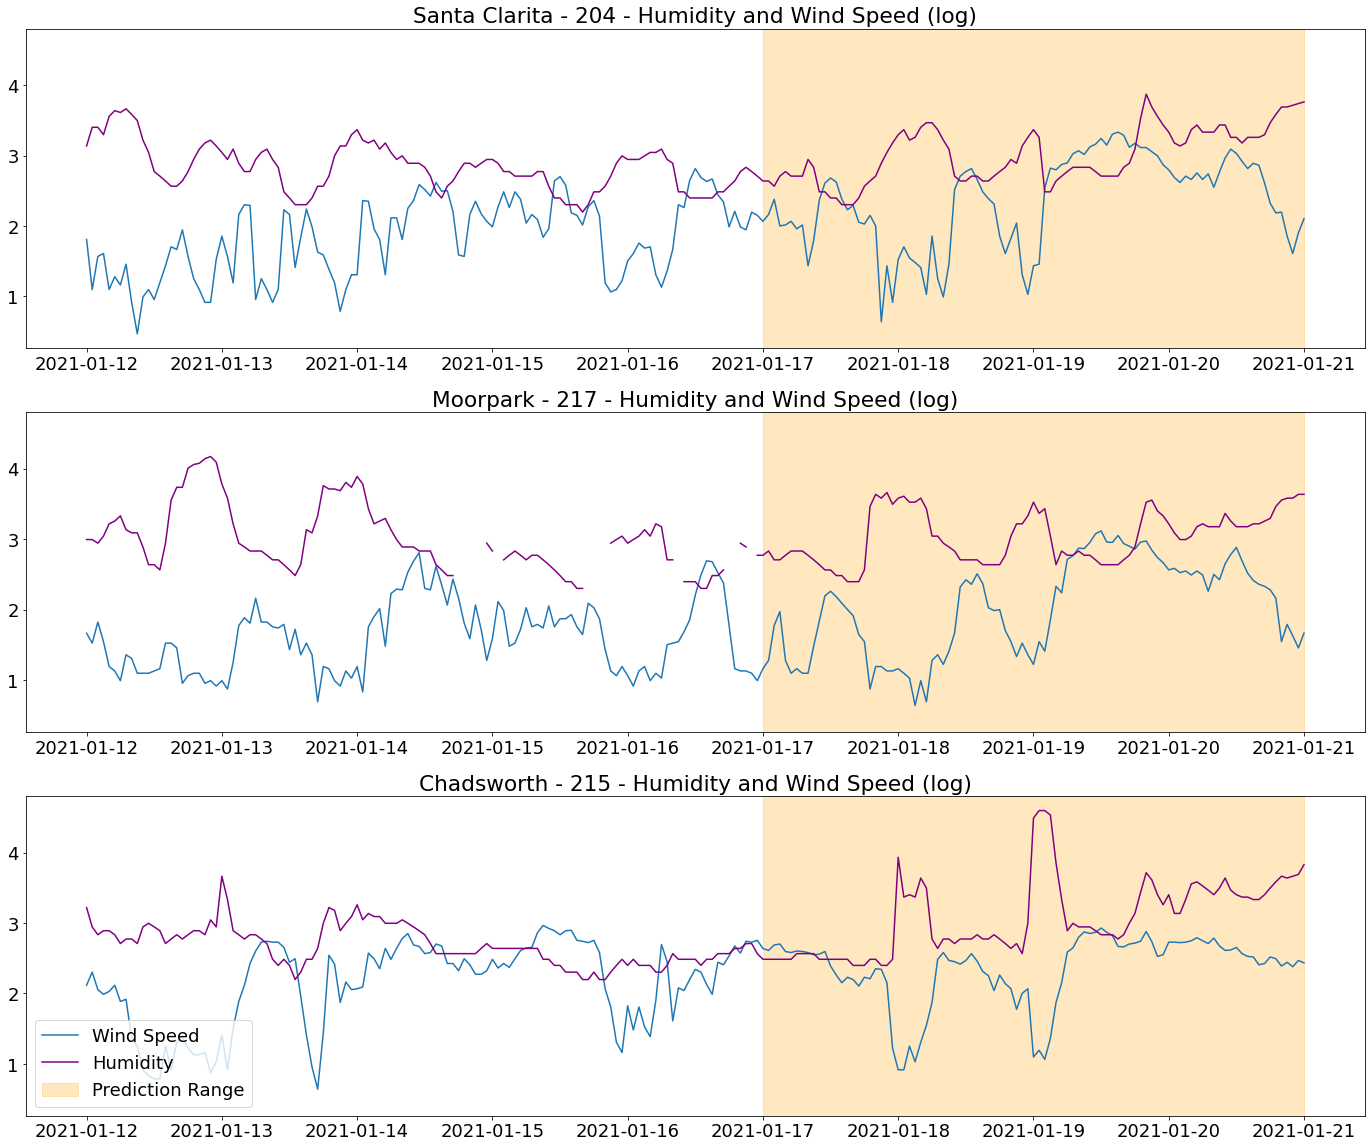

In [131]:
# 44, 219, 237
stations = [204, 217, 215]
dates = se_dates.iloc[8]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        v_ax.axvspan("2021-01-17", end, color='orange', alpha=0.25, label="Prediction Range")

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
plt.savefig("../images/crossings_log.png")



## GlutonTS

In [516]:
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

In [517]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepvar import DeepVAREstimator

In [518]:
#(wr.Date.dt.year >= 2020) & (wr.Date.dt.month >= 12) & (wr.Station.isin(psps_county_stations.values))
wr_gts = ws_wr.copy()
wr_gts.set_index("Time", inplace=True)
# wr_gts = wr_gts[wr_gts.columns[(wr_gts.columns.str.contains("Hly")) | (wr_gts.columns.str.contains("Station"))]]

In [675]:
time_cutoff = "2021-01-19 00:00:00"

datasets = []
single_datasets = []
for (key, df) in wr_gts.groupby(["Station", pd.Grouper(freq='1AS-DEC')]):
    datasets.append({
        "item_id": "{} - {} - {}".format(key[0], wr_ts_columns, key[1]),
        "start": key[1],
        "target": df[wr_ts_columns].loc[:time_cutoff],
        "feat_static_cat": ws.loc[ws.StationNbr == key[0], ws_cat_columns[0]].values.flatten(),
        "feat_static_real": ws.loc[ws.StationNbr == key[0], ws_real_columns].values.flatten()
    })

    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        single_datasets.append({
            "item_id": "{} - {} - {}".format(key[0], c, key[1]),
            "start": key[1],
            "target": df[c].loc[:time_cutoff],
            "feat_static_cat": ws.loc[ws.StationNbr == key[0], ws_cat_columns[0]].values.flatten(),
            "feat_static_real": ws.loc[ws.StationNbr == key[0], ws_real_columns].values.flatten()
        })

In [676]:
all_training_data = ListDataset(
    datasets,
    freq = "1H",
    one_dim_target = False,
)

all_single_training_data = ListDataset(
    single_datasets,
    freq = "1H",
)

In [677]:
next(iter(all_single_training_data))

{'item_id': '2 - HlyAirTmp (F) - 2018-12-01 00:00:00',
 'start': Timestamp('2018-12-01 00:00:00', freq='H'),
 'target': array([41.6, 43.9, 41.7, ..., 53.3, 52.9, 53.2], dtype=float32),
 'feat_static_cat': array([2], dtype=int32),
 'feat_static_real': array([285.], dtype=float32),
 'source': SourceContext(source='list_data', row=0)}

In [521]:
# By default, take up to 3 days before event
training_data = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for df in targets],
    freq = "60min"
)

training_data_3day = training_data

# 2018-2020 Jan only
training_data_year = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2020-02-01 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year < 2020],
    freq = "60min"
)

# Dec 2020 - Jan 2021 only
training_data_2020 = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year == 2020],
    freq = "60min"
)

# 1 week out from PSPS event
training_data_week = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-13 00:00:00"]} for df in targets],
    freq = "60min"
)

# Covers same range as the main training set, except 8 AM to 10 PM only
training_data_morn = ListDataset(
    [{"start": df.index[7], "target": df.loc[(df.index.hour >= 8) & (df.index.hour <= 22) & (df.index <= "2021-01-17 00:00:00")]} for df in targets],
    freq = "60min"
)

# 
training_data_2020_18 = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-19 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year == 2020],
    freq = "60min"
)

### Model Parameters
- model = Deep AR Estimator
- all   = 2018-2021 Dec-Jan Data
- year  = 2018, 2019 Dec-Jan Data only
- d     = days, 7d models are trained from the 17th (8L) and 13th (10L) respectively
- e     = epochs
- L     = Layers
- CL    = Context Length (default = prediction_length)

### Models
- model-all-e100-4L
- model-all-e100-10L
- model-all-e100-20L
- model-year-e100-20L:  Trained on 2018 - Feb 2020 data only
- model-all-e100-10L-7d:  Trained until Jan 13th

In [678]:
estimator = DeepAREstimator(
    freq="1H", 
    prediction_length=24, 
    trainer=Trainer(epochs=50, batch_size=32, learning_rate = 10 ** -3 / 2), 
    num_layers=30,
    num_cells=60,
    use_feat_static_cat = True, cardinality = [wr.Station.unique().shape[0]], 
    use_feat_static_real = True
)

multi_estimator = DeepVAREstimator(
    target_dim = 3,
    freq="1H", 
    prediction_length=3*24, 
    trainer=Trainer(epochs=100, batch_size=32), 
    num_layers=10, 
)

### Train a new model...

In [679]:
predictor = estimator.train(training_data=all_single_training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:59<00:00,  1.20s/it, epoch=50/50, avg_epoch_loss=2.5] 


In [701]:
prefix = "../models/"
model_name = "model-all-e50-30L-24hr"
try:
    os.mkdir(prefix + model_name)
finally:
    predictor.serialize(Path(prefix + model_name))

### ...or load an existing one!

In [217]:
list(filter(lambda s: s.startswith("model"), os.listdir("../models")))

['model-all-e100-20L-morn',
 'model-all-e100-8L-7d',
 'model-all-e100-10L-7d',
 'model-all-e100-10L',
 'model-all-e100-20L-1HR',
 'model-year-e100-20L',
 'model-all-e100-4L',
 'model-2020-e100-20L-1HR',
 'model-all-e100-20L']

In [334]:
predictor = Predictor.deserialize(Path("../models/model-all-e100-20L-1HR"))

### Visualize Predictions

In [355]:
test_station = 204
wr_test = wr_gts[(wr_gts.Station==test_station) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[target_columns]

test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_3day = test_data

test_data_week = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

# Covers same range as the main training set, except 8 AM to 10 PM only
test_data_morn = ListDataset(
    [{"start": wr_test.index[7], "target": wr_test.loc[(wr_test.index.hour >= 8) & (wr_test.index.hour <= 22) & (wr_test.index <= "2021-01-20 00:00:00"), c]} for c in target_columns],
    freq = "60min"
)

test_data_null = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-02-01 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_18 = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-19 18:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [693]:
test_station = 197
wr_test = wr_gts[(wr_gts.Station==test_station) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[wr_ts_columns]

test_datasets = []
test_single_datasets = []

tss = wr_test.transpose().iterrows()
for (c, ts) in tss:
    test_single_datasets.append({
        "start": ts.index[0],
        "target": ts.loc[:"2021-01-20 00:00:00"],
        "feat_static_cat": ws.loc[ws.StationNbr == test_station, ws_cat_columns[0]].values.flatten(),
        "feat_static_real": ws.loc[ws.StationNbr == test_station, ws_real_columns].values.flatten()
    })

In [694]:
all_single_test_data = ListDataset(
    test_single_datasets,
    freq = "1H",
)

In [695]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=all_single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation
)

In [696]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

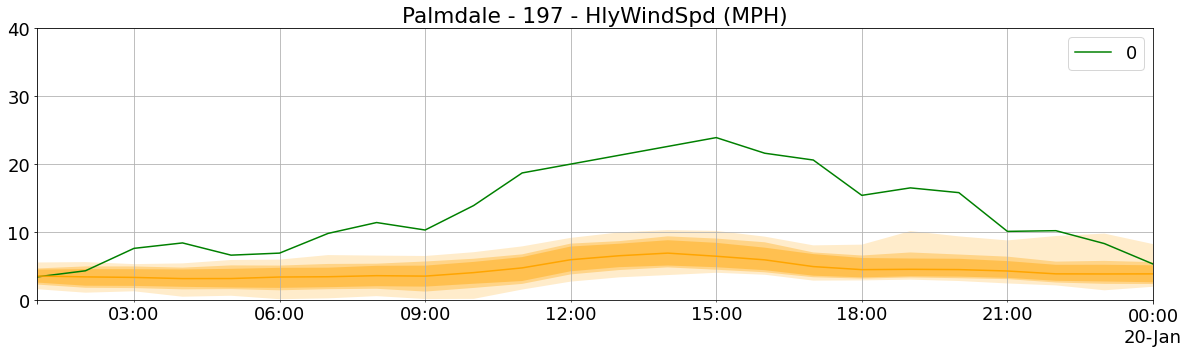

In [700]:
plot_length = 24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

i = 2
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

plt.ylim(0,40)
plt.title("{} - {} - {}".format(ws[ws.StationNbr == test_station].City.values[0], test_station, target_columns[i]))
plt.grid(which="both")
# plt.legend(legend, loc="upper left")
# plt.savefig("../images/204_wind_3day.png")
plt.show()

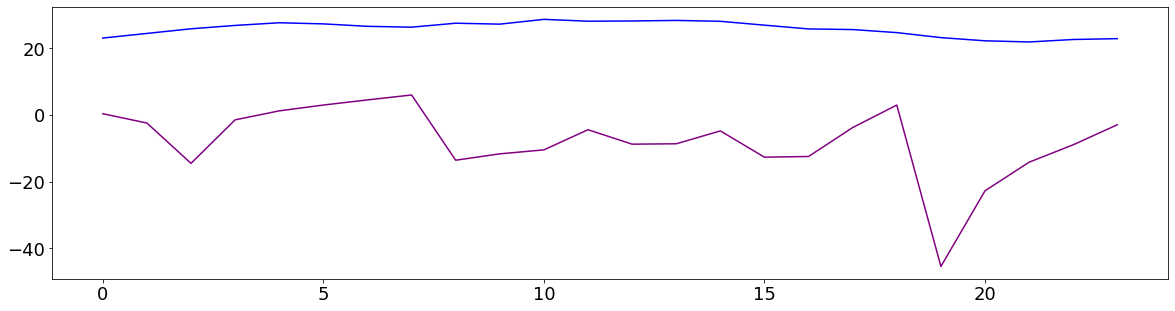

In [620]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

ax.plot(sforecasts[1].samples.min(axis=0), color="purple")
ax.plot(sforecasts[2].samples.max(axis=0), color="blue")

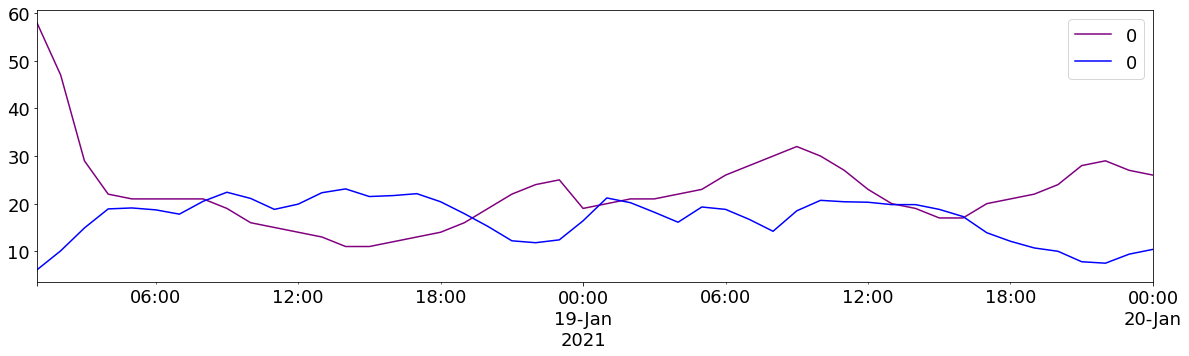

In [621]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

stss[1][-plot_length:].plot(ax=ax, color="purple")  # plot the time series
stss[2][-plot_length:].plot(ax=ax, color="blue")  # plot the time series
plt.show()

### Compute metrics

In [139]:
# metrics = []
# for s in psps_county_stations.values:
#     wr_test = wr_gts[(wr_gts.Station==s) & (wr_gts.Date.dt.year==2021)]
#     wr_test = wr_test[target_columns]
    
#     if len(wr_test.index) == 0:
#         continue
    
#     metric = {}
#     metric["station"] = s

#     test_data = ListDataset(
#         [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
#         freq = "60min"
#     )

#     forecast_it, ts_it = make_evaluation_predictions(
#         dataset=test_data,  # test dataset
#         predictor=predictor,  # predictor
#         num_samples=100,  # number of sample paths we want for evaluation
#     )
    
#     forecasts = list(forecast_it)
#     tss = list(ts_it)
    
#     for i in range(14):
#         metric[target_columns[i]] = sum(tss[i][-int(plot_length/2):].values.reshape(-1) < forecasts[i].quantile(.99))/(plot_length/2)
        
#     metrics.append(metric)


- Metrics computed from 500 samples for 3-day model, 100 samples for 7-day model

In [295]:
test_keys = [key for key in keys if key[1].year == 2020 and key[2] in target_columns[[0,7,13]]]
all_test_data = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in test_keys],
    freq = "60min"
)

all_test_data_18 = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-19 18:00:00"]} for key in test_keys],
    freq = "60min"
)


all_test_data_3day = all_test_data

all_test_data_week = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in test_keys],
    freq = "60min"
)

In [29]:
# Covers same range as the main test set, except 8 AM to 10 PM only
test_data_morn = ListDataset(
    [{"start": df.index[7], "target": df.loc[(df.index.hour >= 8) & (df.index.hour <= 22) & (df.index <= "2021-01-20 00:00:00")]} for df in targets],
    freq = "60min"
)

In [296]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data_18,  # test dataset
    predictor=predictor,  # predictor
    num_samples=200,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_all_it)
tss = list(ts_all_it)

In [297]:
print(len(forecasts), len(tss), len(test_keys))

453 453 453


#### Metric Computations:  % with 99th Percentile

plot_length=2*3*24
metrics = defaultdict(dict)
for (k, f, ts) in zip(test_keys, forecasts, tss):
    metrics[k[0]][k[2]] = sum(ts[-int(plot_length/2):].values.reshape(-1) < f.quantile(.99))/(plot_length/2)

In [45]:
metricsdf = pd.DataFrame(metrics).transpose().sort_index()
metricsdf.head()

,HlyAirTmp (F),HlyRelHum (%),HlyWindSpd (MPH)
2,1.000,1.000000,0.861111
5,1.000,0.986111,0.986111
6,1.000,1.000000,0.458333
7,1.000,1.000000,0.972222
12,0.875,1.000000,0.736111


In [42]:
metricsdf.mean()

HlyAirTmp (F)       0.925957
HlyRelHum (%)       0.954010
HlyWindSpd (MPH)    0.839864
dtype: float64

In [43]:
metricsdf.to_csv("../data/metrics/metrics_2020_e100_20L_1H.csv")

#### Metric Computations:  Crossings

In [76]:
wr_gts.loc[(wr_gts.Station == 234) & (wr_gts.index >= "2021-01-12"), ["Station", "HlyWindSpd (MPH)", "HlyRelHum (%)"]].isna()

,Station,HlyWindSpd (MPH),HlyRelHum (%)
Time,,,
2021-01-12 00:00:00,False,True,True
2021-01-12 01:00:00,False,True,True
2021-01-12 02:00:00,False,True,True
2021-01-12 03:00:00,False,True,True
2021-01-12 04:00:00,False,True,True
...,...,...,...
2021-02-01 20:00:00,False,True,True
2021-02-01 21:00:00,False,True,True
2021-02-01 22:00:00,False,True,True


In [32]:
crossings_forecast = {}
for i in range(int(len(test_keys)/3)):
    crossings_forecast[test_keys[3*i][0]] = (forecasts[3*i+1].samples < forecasts[3*i+2].samples).any(axis=1).mean()
crossings_forecast_series = pd.Series(crossings_forecast)

In [33]:
crossings_forecast_series.sort_values().describe(percentiles=np.arange(0,1,.1))

count    151.000000
mean       0.226656
std        0.266027
min        0.000000
0%         0.000000
10%        0.040000
20%        0.055000
30%        0.065000
40%        0.080000
50%        0.110000
60%        0.135000
70%        0.230000
80%        0.360000
90%        0.685000
max        1.000000
dtype: float64

In [34]:
crossings_forecast_df = pd.DataFrame([crossings_forecast_series, station_crossings]).transpose()
crossings_forecast_df.columns = ["Prob of Crossing", "Actual Crossing Count"]
crossings_forecast_df.fillna(0, inplace=True)

In [283]:
crossings_forecast_df[crossings_forecast_df["Prob of Crossing"] < .5].sort_values("Prob of Crossing")

,Prob of Crossing,Actual Crossing Count
227,0.000,0.0
84,0.005,1.0
205,0.015,0.0
213,0.020,0.0
171,0.025,0.0
...,...,...
200,0.425,0.0
159,0.440,0.0
52,0.460,0.0
116,0.470,2.0


In [307]:
crossings_forecast_df.iloc[44]

Prob of Crossing          0.06
Actual Crossing Count    10.00
Name: 121, dtype: float64

In [84]:
crossings_forecast_df.sort_values("Prob of Crossing").to_csv("../data/metrics/summaries/crossings.csv")

#### Metric Analysis

In [46]:
metrics_dict = {}
for s in os.listdir("../data/metrics"):
    if s.endswith(".csv"):
        metrics_dict[s[:-4]] = pd.read_csv("../data/metrics/" + s).mean(axis=0)
metrics_dict.keys()

dict_keys(['metrics_all_4L', 'metrics_all_e100_10L_7d', 'metrics_all_e100_20L_1H', 'metrics_all', 'metrics_all_10L', 'metrics_year', 'gluon_metrics'])

In [331]:
all_metrics = pd.DataFrame(metrics_dict)
all_metrics.drop("Unnamed: 0", axis=0, inplace=True)
all_metrics[all_metrics.columns.sort_values(ascending=True)]

,metrics_all,metrics_all_10L,metrics_all_4L,metrics_all_e100_10L_7d,metrics_year
HlyAirTmp (F),0.968175,0.912160,0.942329,0.954864,0.959069
HlyRelHum (%),0.974062,0.939478,0.888337,0.969095,0.976729
HlyWindSpd (MPH),0.925497,0.892476,0.651950,0.903658,0.834437


- What is the floating precision of the model parameters?  8?  32?
- How about 10 layers?
- What about minimum thresholds, cutting off low wind values?  Exclude evening values, train on day's values

In [168]:
metricsdf_new = pd.read_csv("../data/metrics/metrics_all_new.csv").set_index("Unnamed: 0")
metricsdf_new.loc[204]

HlyAirTmp (F)       1.000000
HlyRelHum (%)       1.000000
HlyWindSpd (MPH)    0.916667
Name: 204, dtype: float64

### Gluon-ts Metrics

In [77]:
models_eval = list(filter(lambda s: s.startswith("model") and "morn" not in s and "7d" not in s, os.listdir("../models")))
models_eval

['model-all-e100-10L',
 'model-all-e100-20L-1HR',
 'model-year-e100-20L',
 'model-all-e100-4L',
 'model-2020-e100-20L-1HR',
 'model-all-e100-20L']

In [156]:
model_names = ["10 Layer", "20 Layer, 1HR",  "2018-2020", "4 Layer", "2020-2021", "20 Layer"]
model_names_ordered = ["4 Layer", "10 Layer", "20 Layer", "2018-2020", "2020-2021"]

In [63]:
pred_eval = Predictor.deserialize(Path("../models/model-year-e100-20L"))

In [304]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data_18,  # test dataset
    predictor=predictor,  # predictor
    num_samples=200,  # number of sample paths we want for evaluation
)
# forecasts = list(forecast_all_it)
# tss = list(ts_all_it)

In [305]:
evaluator = Evaluator(quantiles=[0.5, 0.75, .90, .95, 0.99])
agg_metrics, item_metrics = evaluator(ts_all_it, forecast_all_it, num_series=len(all_test_data_18))

Running evaluation: 100%|██████████| 453/453 [02:23<00:00,  3.16it/s]


In [306]:
# print(json.dumps(agg_metrics, indent=4))
agg_metrics

{'MSE': 300.76733684265747,
 'abs_error': 82122.27570462227,
 'abs_target_sum': 261924.20038604736,
 'abs_target_mean': 32.5028463951012,
 'seasonal_error': 6.3076944880021175,
 'MASE': 1.9719952120874624,
 'MAPE': 0.45821373944279875,
 'sMAPE': 0.394329983770176,
 'OWA': nan,
 'MSIS': 16.54868477994483,
 'QuantileLoss[0.5]': 82122.27599556744,
 'Coverage[0.5]': 0.6058298319327732,
 'QuantileLoss[0.75]': 72398.90742503852,
 'Coverage[0.75]': 0.7388174019607844,
 'QuantileLoss[0.9]': 49183.705477499956,
 'Coverage[0.9]': 0.854079131652661,
 'QuantileLoss[0.95]': 33740.69382051828,
 'Coverage[0.95]': 0.9106632236227826,
 'QuantileLoss[0.99]': 12554.740353665362,
 'Coverage[0.99]': 0.9754245448179272,
 'RMSE': 17.342645035941246,
 'NRMSE': 0.5335731161857601,
 'ND': 0.31353450953971834,
 'wQuantileLoss[0.5]': 0.31353451065051746,
 'wQuantileLoss[0.75]': 0.27641167680699424,
 'wQuantileLoss[0.9]': 0.18777839315728978,
 'wQuantileLoss[0.95]': 0.12881854281043226,
 'wQuantileLoss[0.99]': 0.0

In [78]:
pred_metrics = {}
evaluator = Evaluator(quantiles=[0.5, 0.75, 0.99])

In [79]:
for m in models_eval:
    print("Evaluating:  ", m)
    pred_eval = Predictor.deserialize(Path("../models/" + m))
    
    forecast_eval, ts_eval = make_evaluation_predictions(
        dataset=all_test_data,  # test dataset
        predictor=pred_eval,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    agg_metrics, item_metrics = evaluator(ts_eval, forecast_eval, num_series=len(all_test_data))
    
    pred_metrics[m] = agg_metrics

Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-10L


Running evaluation: 100%|██████████| 453/453 [02:16<00:00,  3.32it/s]
/usr/local/anaconda3/envs/gluon-ts/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1516: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)
Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-20L-1HR


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-year-e100-20L


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-4L


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-2020-e100-20L-1HR


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-20L


Running evaluation: 100%|██████████| 453/453 [04:36<00:00,  1.64it/s]


In [165]:
pred_metrics.keys()

dict_keys(['model-all-e100-10L', 'model-all-e100-20L-1HR', 'model-year-e100-20L', 'model-all-e100-4L', 'model-2020-e100-20L-1HR', 'model-all-e100-20L'])

In [166]:
gluon_metrics_df = pd.DataFrame(pred_metrics)
gluon_metrics_df

,model-all-e100-10L,model-all-e100-20L-1HR,model-year-e100-20L,model-all-e100-4L,model-2020-e100-20L-1HR,model-all-e100-20L
MSE,4.090408e+02,5.212673e+02,4.455226e+02,3.637841e+02,3.408710e+03,4.575544e+02
abs_error,3.532406e+05,3.681334e+05,3.680518e+05,4.528045e+05,1.095240e+06,3.712727e+05
abs_target_sum,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06
abs_target_mean,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01
seasonal_error,2.360803e+00,6.274191e+00,2.360803e+00,2.360803e+00,6.274191e+00,2.360803e+00
MASE,4.487001e+00,1.945889e+00,4.609849e+00,6.133572e+00,5.376023e+00,4.582029e+00
MAPE,5.120254e-01,5.453917e-01,5.227245e-01,4.598822e-01,1.194702e+00,5.239230e-01
sMAPE,4.339599e-01,4.684550e-01,4.375678e-01,5.109209e-01,5.885626e-01,4.217320e-01
OWA,NaN,NaN,NaN,NaN,NaN,NaN
MSIS,5.932696e+01,2.301594e+01,6.027836e+01,7.005593e+01,3.187385e+01,5.569598e+01


In [167]:
model_names

['10 Layer', '20 Layer, 1HR', '2018-2020', '4 Layer', '2020-2021', '20 Layer']

In [168]:
gluon_metrics_df.columns = model_names

In [169]:
gluon_metrics_df["2020-2021"] = agg_metrics.values()
gluon_metrics_df

,10 Layer,"20 Layer, 1HR",2018-2020,4 Layer,2020-2021,20 Layer
MSE,4.090408e+02,5.212673e+02,4.455226e+02,3.637841e+02,4.341669e+02,4.575544e+02
abs_error,3.532406e+05,3.681334e+05,3.680518e+05,4.528045e+05,3.583955e+05,3.712727e+05
abs_target_sum,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06
abs_target_mean,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01
seasonal_error,2.360803e+00,6.274191e+00,2.360803e+00,2.360803e+00,6.274191e+00,2.360803e+00
MASE,4.487001e+00,1.945889e+00,4.609849e+00,6.133572e+00,1.880204e+00,4.582029e+00
MAPE,5.120254e-01,5.453917e-01,5.227245e-01,4.598822e-01,5.267235e-01,5.239230e-01
sMAPE,4.339599e-01,4.684550e-01,4.375678e-01,5.109209e-01,4.424404e-01,4.217320e-01
OWA,NaN,NaN,NaN,NaN,NaN,NaN
MSIS,5.932696e+01,2.301594e+01,6.027836e+01,7.005593e+01,2.443293e+01,5.569598e+01


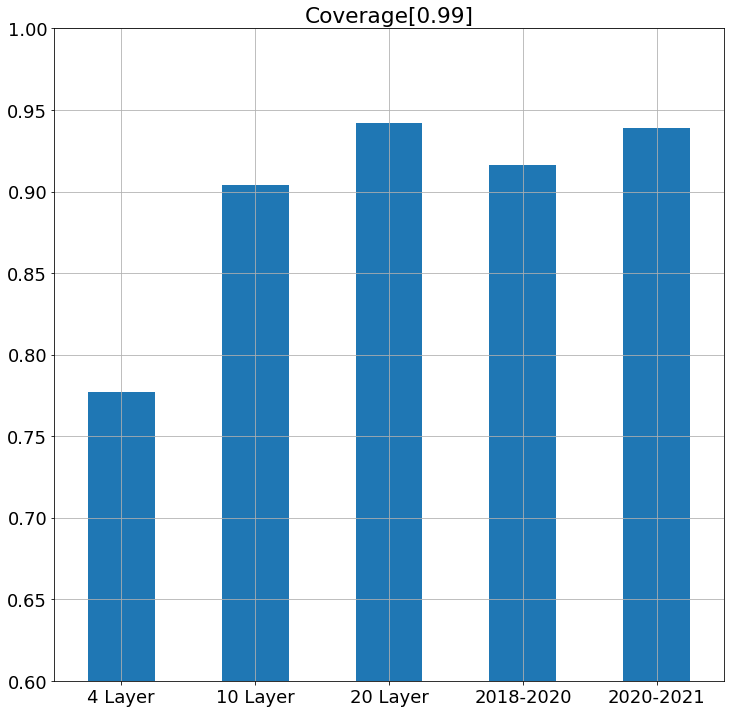

In [191]:
metric_list = ["MAPE", "MASE", "Coverage[0.75]", "Coverage[0.99]"]

i=3
gluon_metrics_df[model_names_ordered].loc[metric_list[i]].plot.bar(rot=0, figsize=(12,12))

plt.ylim(.6,1)
# plt.yticks(np.arange(.2,.7,.05))

plt.title(metric_list[i])
plt.grid(True)

plt.savefig("../images/{}.png".format(metric_list[i]))


In [81]:
gluon_metrics_df.columns

Index(['model-all-e100-10L', 'model-all-e100-20L-1HR', 'model-year-e100-20L',
       'model-all-e100-4L', 'model-2020-e100-20L-1HR', 'model-all-e100-20L'],
      dtype='object')

In [74]:
model_order = ['model-all-e100-4L', 'model-all-e100-10L' , 'model-all-e100-20L', 'model-year-e100-20L', 'model-all-e100-20L-morn']
gluon_metrics_df[model_order]

,model-all-e100-4L,model-all-e100-10L,model-all-e100-20L,model-year-e100-20L,model-all-e100-20L-morn
MSE,3.617048e+02,4.122161e+02,4.619693e+02,4.403877e+02,5.651287e+02
abs_error,4.521496e+05,3.534724e+05,3.716892e+05,3.667884e+05,4.395308e+05
abs_target_sum,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06
abs_target_mean,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01
seasonal_error,2.360803e+00,2.360803e+00,2.360803e+00,2.360803e+00,2.360803e+00
MASE,6.130031e+00,4.491303e+00,4.590389e+00,4.604018e+00,5.278972e+00
MAPE,4.612168e-01,5.111790e-01,5.254450e-01,5.199554e-01,6.131353e-01
sMAPE,5.109093e-01,4.339274e-01,4.228703e-01,4.368863e-01,4.512471e-01
OWA,NaN,NaN,NaN,NaN,NaN
MSIS,7.026964e+01,6.032109e+01,5.560632e+01,5.906018e+01,7.081799e+01


In [82]:
gluon_metrics_df.dropna().to_csv("../data/metrics/gluon_metrics_latest.csv")